In [1]:
'''
File name: preprocessing.ipynb
Authors: Yasmin El Euch, Aliénor Bénédicte G Hamoir, Clara Rossignol, Guillaume David E. Ryelandt
Date created: 04/11/2022
Date last modified: 18/11/2022
Python version: 3.8.8
'''

'\nFile name: preprocessing.ipynb\nAuthors: Yasmin El Euch, Aliénor Bénédicte G Hamoir, Clara Rossignol, Guillaume David E. Ryelandt\nDate created: 04/11/2022\nDate last modified: 18/11/2022\nPython version: 3.8.8\n'

# The evolution of the gender gap in the film industry

Our goal with this work is to analyze the evolution in time of sexism and women discrimination in the film industry, which is known as one of the least women-friendly industries: [almost 9 in 10 films (89%) have more men in their 10 or so most senior roles, both acting and non-acting](https://www.bbc.com/culture/article/20180508-the-data-that-reveals-the-film-industrys-woman-problem). The #MeToo movement, known for its apogee in 2017 with the complaints of many known actresses about the sexism and assaults in the film industry, appeared in reality in 2007. It made less noise back then, but it was present and in many fields. The premises of free speech and liberation about the harassment, assault and rape culture women were suffering of, were launched. We want to tell the story of those women, particularly in the film industry, who suffer from daily discrimination. We want to have a look at the gender gap and how it has evolved in time, especially after the appearance of the #MeToo movement? Finally, the goal is to assess whether this movement has had a real impact on the situation.

## Table of contents

0. [General Information](#GI)\
        A. [Folder structure](#Folder)\
        B. [Data](#Data)\
        C. [Imports](#Imports)\
        D. [Paths](#Paths)

1. [Data scraping, pre-processing and dataset construction](#Step-1)\
        A. [Pre-processing](#Pre-pro)\
        B. [First insights on gender gap](#First_insights)

2. [Box office revenues, salaries](#Box_Office)
3. [Detecting main characters](#Main_characters)
4. [Discrimination through types of roles attribution and its evolution in time](#Types)


---
## General Information <a id="GI"> </a> 

### Folder structure <a id="Folder"> </a>

***Files and directories to make this notebook run successfully:***

- **data/**
    - *character.metadata.tsv*
    - *movie.metadata.tsv*
    - *name.clusters.txt*
    - *plot_summaries.txt*
    - *tvtropes.clusters.txt*
    - *oscar_winners.csv*
    - *movie_appreciation_metadata.csv*


- *preprocessing.ipynb*

Directories are in **bold** and files are in *italic*.

`movie.metadata.tsv.gz` [3.4 M]

Metadata for 81,741 movies, extracted from the November 4, 2012 dump of Freebase. Tab-separated. The columns are:

1. Wikipedia movie ID
2. Freebase movie ID
3. Movie name
4. Movie release date
5. Movie box office revenue
6. Movie runtime
7. Movie languages (Freebase ID:name tuples)
8. Movie countries (Freebase ID:name tuples)
9. Movie genres (Freebase ID:name tuples)


`name.clusters.txt`

970 unique character names used in at least two different movies, along with 2,666 instances of those types.  The ID field indexes into the Freebase character/actor map ID in character.metadata.tsv.


`plot_summaries.txt.gz` [29 M] 

Plot summaries of 42,306 movies extracted from the November 2, 2012 dump of English-language Wikipedia.  Each line contains the Wikipedia movie ID (which indexes into movie.metadata.tsv) followed by the summary.


`tvtropes.clusters.txt`

72 character types drawn from tvtropes.com, along with 501 instances of those types.  The ID field indexes into the Freebase character/actor map ID in character.metadata.tsv.


`corenlp_plot_summaries.tar.gz` [628 M, separate download]

The plot summaries from above, run through the Stanford CoreNLP pipeline (tagging, parsing, NER and coref). Each filename begins with the Wikipedia movie ID (which indexes into movie.metadata.tsv).


### Imports <a id="Imports"> </a>

***Libraries used for milestone 2:***
- python=3.8.12
- pandas
- ast
- datetime
- seaborn
- numpy
- matplotlib
- json

In [72]:
#Imports used in this notebook
from datetime import datetime

import ast
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json as js 
import datetime as dt

### Paths <a id="Paths"> </a>

Required to adapt those path to local file organization

In [73]:
### PATHs for dataset:
PATH_DATA = 'data/'

PATH_MOVIE_METADATA = PATH_DATA+'movie.metadata.tsv'
PATH_PLOT_SUMMARY = PATH_DATA+'plot_summaries.txt'
PATH_CHARACTER_METADATA = PATH_DATA+'character.metadata.tsv'
PATH_NAME_CLUSTERS=PATH_DATA+'name.clusters.txt'
PATH_TV_TROPES_CLUSTERS=PATH_DATA+'tvtropes.clusters.txt'

#additionnal datasets:
PATH_MOVIE_OSCAR_WINNERS = PATH_DATA+'oscar_winners.csv'
PATH_MOVIE_APPRECIATION = PATH_DATA+'movie_appreciation_metadata.csv'

---
##  Data scraping, pre-processing and dataset construction<a id="Step-1"> </a>

### Pre-processing <a id="#Pre-pro"> </a>

In [74]:
def dict_to_cols(row): 
    '''
    Allows to transform the dictionnary into a dataframe with multiple columns.
    :param row : row to transform
    :return : 
    '''
    d = js.loads(row[1])
    return row[0], *list(d.values())

def dict_to_lst(stri):
    '''
    Allows to transform a dictionnary into a list of features.
    :param stri : 
    :return : list of features
    '''
    dict = ast.literal_eval(stri)
    lst  = list(dict.values())
    return lst

First we will properly name ecach column of  in order to manipulate in an easier way

In [75]:
print("Reading in movie data")


movie_headers = ['Wikipedia_movie_ID', 'Freebase_movie_ID', 'Movie_name','Movie_release_date','Movie_box_office_revenue',
                 'Movie_runtime','Movie_languages','Movie_countries','Movie_genres']
plot_headers = ['Wikipedia_movie_ID','Plot_Summary']
character_headers = ['Wikipedia_movie_ID', 'Freebase_movie_ID','Movie_release_date','Character_name','Actor_date_of_birth',
                     'Actor_gender','Actor_height','Actor_ethnicity','Actor_name','Actor_age_at_movie_release',
                     'Freebase_character_actor_map_ID','Freebase_character_ID','Freebase_actor_ID']
name_clusters_headers=['Character_name', 'id']
tv_tropes_cluster_headers=['Trope','Character_name','movie','id','actor']
new_cols_apprec=['movie_title','director name','duration','country','actor_1_name','actor_2_name','actor_3_name',
                    'movie_facebook_likes','actor_1_facebook_likes','actor_2_facebook_likes','actor_3_facebook_likes',
                    'director_facebook_likes','gross','genres','num_voted_users','cast_total_facebook_likes',
                    'facenumber_in_poster','num_user_for_reviews','content_rating','budget',
                    'title_year','imdb_score','aspect_ratio'
                    ]
#Read in movie metadata, plot summaries, and character metadata.
movie_metadata = pd.read_csv(PATH_MOVIE_METADATA,sep='\t',header=None,names=movie_headers,index_col=0)
plot_summaries = pd.read_csv(PATH_PLOT_SUMMARY,sep='\t',index_col=0,names=plot_headers)
character_metadata = pd.read_csv(PATH_CHARACTER_METADATA,sep='\t',header=None,names=character_headers,index_col='Wikipedia_movie_ID')
name_clusters=pd.read_csv(PATH_NAME_CLUSTERS,sep='\t',header=None,names=name_clusters_headers,index_col='id')
tv_tropes_clusters = pd.read_csv(PATH_TV_TROPES_CLUSTERS,sep='\t',header=None).apply(dict_to_cols, axis=1, result_type='expand')
#reading additionnal datasets
movie_appreciation_metadata = pd.read_csv(PATH_MOVIE_APPRECIATION,header=0)
movie_oscar_winners=pd.read_csv(PATH_MOVIE_OSCAR_WINNERS,header=0)

tv_tropes_clusters.columns = tv_tropes_cluster_headers
tv_tropes_clusters.set_index('id')
movie_metadata['Movie_languages']=movie_metadata['Movie_languages'].apply(lambda x: dict_to_lst(x))
movie_metadata['Movie_countries']=movie_metadata['Movie_countries'].apply(lambda x: dict_to_lst(x))
movie_metadata['Movie_genres']=movie_metadata['Movie_genres'].apply(lambda x: dict_to_lst(x))
#cleaning for the additionnal dataset
movie_appreciation_metadata.drop(['color','movie_imdb_link'], axis=1)
movie_apprciation_metadata=movie_appreciation_metadata.reindex(columns=new_cols_apprec)
movie_oscar_winners=movie_oscar_winners.replace('1927/1928','1928').replace('1928/1929','1929').replace(
    '1929/1930','1930').replace('1930/1931','1931').replace('1931/1932','1932').replace('1932/1933','1933')

display(movie_metadata.head())
display(plot_summaries.head())
display(character_metadata.head())
display(name_clusters.head())
display(tv_tropes_clusters.head())
display(movie_appreciation_metadata.head())
display(movie_oscar_winners.head())

Reading in movie data


,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
Wikipedia_movie_ID,,,,,,,,
975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
28463795,/m/0crgdbh,Brun bitter,1988,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
9363483,/m/0285_cd,White Of The Eye,1987,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
261236,/m/01mrr1,A Woman in Flames,1983,NaN,106.0,[German Language],[Germany],[Drama]


,Plot_Summary
Wikipedia_movie_ID,
23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
31186339,The nation of Panem consists of a wealthy Capi...
20663735,Poovalli Induchoodan is sentenced for six yea...
2231378,"The Lemon Drop Kid , a New York City swindler,..."
595909,Seventh-day Adventist Church pastor Michael Ch...


,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID
Wikipedia_movie_ID,,,,,,,,,,,,
975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


,Character_name
id,
/m/0k3w9c,Stuart Little
/m/0k3wcx,Stuart Little
/m/0k3wbn,Stuart Little
/m/0jyg35,John Doe
/m/0k2_zn,John Doe


,Trope,Character_name,movie,id,actor
0,absent_minded_professor,Professor Philip Brainard,Flubber,/m/0jy9q0,Robin Williams
1,absent_minded_professor,Professor Keenbean,Richie Rich,/m/02vchl3,Michael McShane
2,absent_minded_professor,Dr. Reinhardt Lane,The Shadow,/m/0k6fkc,Ian McKellen
3,absent_minded_professor,Dr. Harold Medford,Them!,/m/0k6_br,Edmund Gwenn
4,absent_minded_professor,Daniel Jackson,Stargate,/m/0k3rhh,James Spader


,color,director_name,num_critic_for_reviews,duration,director_facebook_likes,actor_3_facebook_likes,actor_2_name,actor_1_facebook_likes,gross,genres,...,num_user_for_reviews,language,country,content_rating,budget,title_year,actor_2_facebook_likes,imdb_score,aspect_ratio,movie_facebook_likes
0,Color,James Cameron,723.0,178.0,0.0,855.0,Joel David Moore,1000.0,760505847.0,Action|Adventure|Fantasy|Sci-Fi,...,3054.0,English,USA,PG-13,237000000.0,2009.0,936.0,7.9,1.78,33000
1,Color,Gore Verbinski,302.0,169.0,563.0,1000.0,Orlando Bloom,40000.0,309404152.0,Action|Adventure|Fantasy,...,1238.0,English,USA,PG-13,300000000.0,2007.0,5000.0,7.1,2.35,0
2,Color,Sam Mendes,602.0,148.0,0.0,161.0,Rory Kinnear,11000.0,200074175.0,Action|Adventure|Thriller,...,994.0,English,UK,PG-13,245000000.0,2015.0,393.0,6.8,2.35,85000
3,Color,Christopher Nolan,813.0,164.0,22000.0,23000.0,Christian Bale,27000.0,448130642.0,Action|Thriller,...,2701.0,English,USA,PG-13,250000000.0,2012.0,23000.0,8.5,2.35,164000
4,NaN,Doug Walker,NaN,NaN,131.0,NaN,Rob Walker,131.0,NaN,Documentary,...,NaN,NaN,NaN,NaN,NaN,NaN,12.0,7.1,NaN,0


,Year,Ceremony,Award,Winner,Name,Film
0,1928,1,Actor,NaN,Richard Barthelmess,The Noose
1,1928,1,Actor,1.0,Emil Jannings,The Last Command
2,1928,1,Actress,NaN,Louise Dresser,A Ship Comes In
3,1928,1,Actress,1.0,Janet Gaynor,7th Heaven
4,1928,1,Actress,NaN,Gloria Swanson,Sadie Thompson


We have extracted the data and can see that there is some preprocessing to be done.

`movie.metadata.tsv.gz`
Firstly, the movie release dates are not standardized: some are in a year-month-day format and some only have the release year. Secondly, for some of the columns (Movie languages, Movie countries, and Movie genres) the way we the data is presented might not be the best (dictionary with ID and actual "value).
We also need to look for any column containing NaN values and see what we want to do with these missing values. Depending on what data we need for each of our research axis, we might deal differently with NaNs.

We can see that some values are missing, movie languages, movie countries and movie genres are lists. Also the dates don't all have the same format, in fact, some are missing the month and day. 

In [6]:
name_clusters.head()

,Character_name
id,
/m/0k3w9c,Stuart Little
/m/0k3wcx,Stuart Little
/m/0k3wbn,Stuart Little
/m/0jyg35,John Doe
/m/0k2_zn,John Doe


This data set shows the characters appearing in different movies. This might be unuselful for our analysis since we analyze movies one by one.

First of all, we make an inspection of the dataframes, to see wether there exist some duplicates, NaN values etc... 

In [7]:
movie_metadata.index.is_unique

True

In [8]:
movie_metadata.isna().any()

Freebase_movie_ID           False
Movie_name                  False
Movie_release_date           True
Movie_box_office_revenue     True
Movie_runtime                True
Movie_languages             False
Movie_countries             False
Movie_genres                False
dtype: bool

Here is a more visual way to see which columns of the dataset contain missing entries. Such that, every white line is a missing value of the dataset.

Sum of NaN in each feature : 


Freebase_movie_ID               0
Movie_name                      0
Movie_release_date           6902
Movie_box_office_revenue    73340
Movie_runtime               20450
Movie_languages                 0
Movie_countries                 0
Movie_genres                    0
dtype: int64

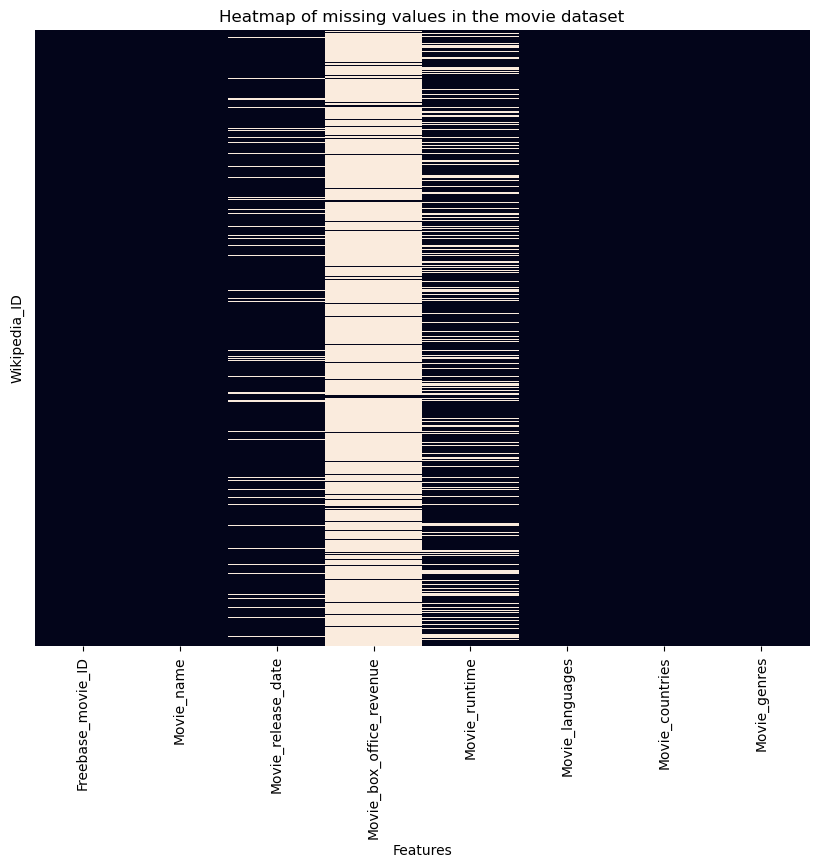

In [9]:
fig, ax = plt.subplots(figsize=(10,8)) 
sns.heatmap(movie_metadata.isna(), yticklabels=False, cbar=False)
ax.set(xlabel="Features", ylabel="Wikipedia_ID")
ax.set_title('Heatmap of missing values in the movie dataset')

print('Sum of NaN in each feature : ')
movie_metadata.isna().sum(axis = 0)

In [10]:
n_movie=len(movie_metadata)
print('Percentage of missing entries in the movie.metadata dataset:\n', 100*movie_metadata[['Movie_release_date', 'Movie_box_office_revenue', 'Movie_runtime']].isna().sum() / n_movie)

Percentage of missing entries in the movie.metadata dataset:
 Movie_release_date           8.443743
Movie_box_office_revenue    89.722416
Movie_runtime               25.018045
dtype: float64


We are missing a lot of the data on the movie box office revenue. Maybe we should try and find those missing informations in another dataset as this could be helpful in our analysis. For the release dates and runtime we could discard the rows with missing values but it could be interesting to check if the rows discarded contain on average more or less lead women characters  or women directors so that we don't overlook any data.

`plot_summaries.txt.gz`

In [11]:
print("Reading in summaries data")
plot_summaries.head()

Reading in summaries data


,Plot_Summary
Wikipedia_movie_ID,
23890098,"Shlykov, a hard-working taxi driver and Lyosha..."
31186339,The nation of Panem consists of a wealthy Capi...
20663735,Poovalli Induchoodan is sentenced for six yea...
2231378,"The Lemon Drop Kid , a New York City swindler,..."
595909,Seventh-day Adventist Church pastor Michael Ch...


In [12]:
plot_summaries.index.is_unique

True

In [13]:
print('Sum of NaN in each feature : ')
plot_summaries.isna().sum(axis = 0)

Sum of NaN in each feature : 


Plot_Summary    0
dtype: int64

The summary dataset seems to be relatively clean in term of completeness of information.

`character.metadata.tsv.gz`

In [14]:
print("Reading in character data")
character_metadata.head()

Reading in character data


,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID
Wikipedia_movie_ID,,,,,,,,,,,,
975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


In [15]:
character_metadata.isna().any()

Freebase_movie_ID                  False
Movie_release_date                  True
Character_name                      True
Actor_date_of_birth                 True
Actor_gender                        True
Actor_height                        True
Actor_ethnicity                     True
Actor_name                          True
Actor_age_at_movie_release          True
Freebase_character_actor_map_ID    False
Freebase_character_ID               True
Freebase_actor_ID                   True
dtype: bool

Sum of NaN in each feature : 


Freebase_movie_ID                       0
Movie_release_date                   9995
Character_name                     257875
Actor_date_of_birth                106145
Actor_gender                        45609
Actor_height                       295845
Actor_ethnicity                    344611
Actor_name                           1228
Actor_age_at_movie_release         158113
Freebase_character_actor_map_ID         0
Freebase_character_ID              257865
Freebase_actor_ID                     815
dtype: int64

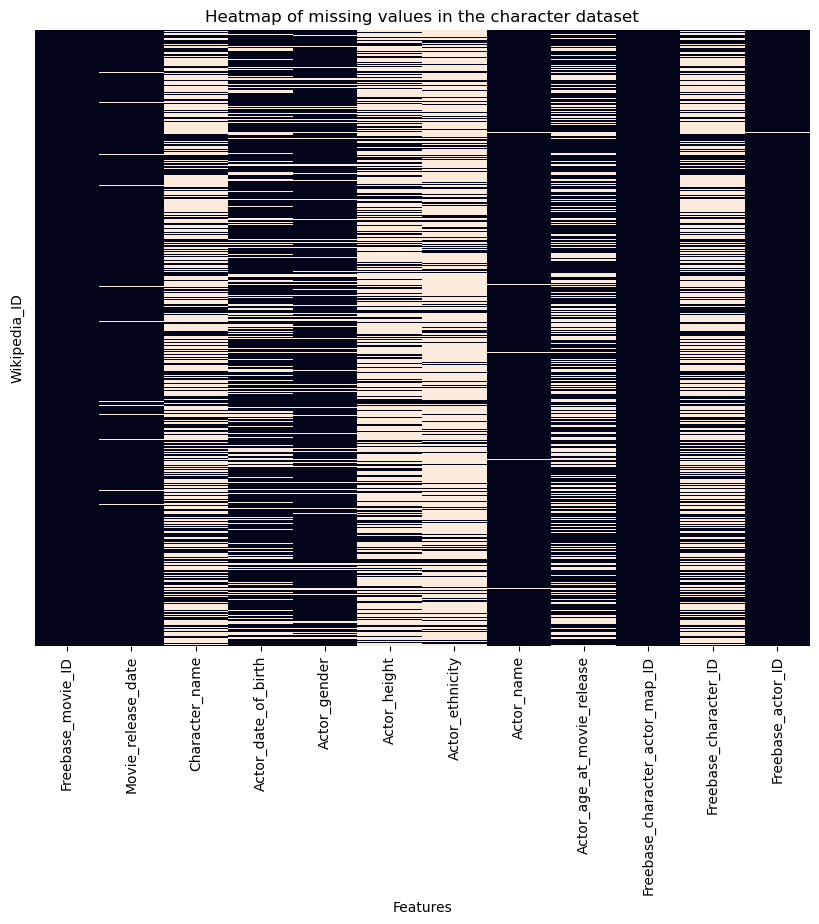

In [16]:
fig, ax = plt.subplots(figsize=(10,8)) 
sns.heatmap(character_metadata.isna(), yticklabels=False, cbar=False)
ax.set(xlabel="Features", ylabel="Wikipedia_ID")
ax.set_title('Heatmap of missing values in the character dataset')
print('Sum of NaN in each feature : ')
character_metadata.isna().sum(axis = 0)

The white lines stand for missing values.

In [17]:
n_char=len(character_metadata)
print('Percentage of missing entries in the character.metadata dataset:\n', 100*character_metadata[['Freebase_movie_ID', 'Movie_release_date', 'Character_name',
                                                                                   'Actor_date_of_birth', 'Actor_gender', 'Actor_height', 'Actor_ethnicity',
                                                                                   'Actor_name', 'Actor_age_at_movie_release', 'Freebase_character_ID',
                                                                                   'Freebase_actor_ID']].isna().sum() / n_char)

Percentage of missing entries in the character.metadata dataset:
 Freebase_movie_ID              0.000000
Movie_release_date             2.217814
Character_name                57.220488
Actor_date_of_birth           23.552763
Actor_gender                  10.120288
Actor_height                  65.645740
Actor_ethnicity               76.466542
Actor_name                     0.272484
Actor_age_at_movie_release    35.084064
Freebase_character_ID         57.218269
Freebase_actor_ID              0.180842
dtype: float64


We are missing a lot of data on actor's and actresses' ethnicities and their heights. This should not affect our analysis a we did not plan on using these features initially. For the other features we need to figure out if they are relevant to our analysis, and if so, need to decide wheter we want to discard the rows containing NaNs or try and find the information elsewhere.

In [18]:
character_dropna = character_metadata.dropna()
character_dropna.head()

,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID
Wikipedia_movie_ID,,,,,,,,,,,,
975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
975900,/m/03vyhn,2001-08-24,Commander Helena Braddock,1949-05-26,F,1.727,/m/0x67,Pam Grier,52.0,/m/02vdcfp,/m/0bgchnd,/m/0418ft
2314463,/m/0734w5,2006,Taper Guy,1971-05-26,M,1.870,/m/033tf_,Matt Stone,34.0,/m/0cgn0lx,/m/0h0z488,/m/01_x6d
612710,/m/02wjqm,1999-10-01,Sandii,1975-09-20,F,1.680,/m/0222qb,Asia Argento,24.0,/m/02vcxk_,/m/0h2l6rx,/m/028pzq


In [19]:
n_movie = len(movie_metadata)
n_summaries = len(plot_summaries)
n_char = len(character_metadata)
n_name_clusters = len(name_clusters)
n_tropes_clusters = len(tv_tropes_clusters)
n_appr = len(movie_appreciation_metadata)
n_osc = len(movie_oscar_winners)

print('Number of rows in the movie.metadata dataset : %d' %n_movie)
print('Number of rows in the plot_summaries dataset : %d' %n_summaries)
print('Number of rows in the character.metadata dataset : %d' %n_char)
print('Number of rows in the name.clusters dataset : %d' %n_name_clusters)
print('Number of rows in the movie_appreciation_metadata dataset : %d' %n_appr)
print('Number of rows in the movie_oscar_winners dataset : %d' %n_osc)

Number of rows in the movie.metadata dataset : 81741
Number of rows in the plot_summaries dataset : 42303
Number of rows in the character.metadata dataset : 450669
Number of rows in the name.clusters dataset : 2666
Number of rows in the movie_appreciation_metadata dataset : 5043
Number of rows in the movie_oscar_winners dataset : 9964


In [20]:
print("What is needed to be processed:")
print("Rows with actor age at movie release under or equal to 0: %d" %len(character_metadata[character_metadata['Actor_age_at_movie_release']<=0]))
print("Rows with actor height under or equal to 0: %d" %len(character_metadata[character_metadata['Actor_height']<=0]))
print("Rows with movie runtime under or equal to 0: %d" %len(movie_metadata[movie_metadata['Movie_runtime']<=0]))
character_metadata

What is needed to be processed:
Rows with actor age at movie release under or equal to 0: 433
Rows with actor height under or equal to 0: 0
Rows with movie runtime under or equal to 0: 1


,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID
Wikipedia_movie_ID,,,,,,,,,,,,
975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
...,...,...,...,...,...,...,...,...,...,...,...,...
913762,/m/03pcrp,1992-05-21,Elensh,1970-05,F,NaN,NaN,Dorothy Elias-Fahn,NaN,/m/0kr406c,/m/0kr406h,/m/0b_vcv
913762,/m/03pcrp,1992-05-21,Hibiki,1965-04-12,M,NaN,NaN,Jonathan Fahn,27.0,/m/0kr405_,/m/0kr4090,/m/0bx7_j
28308153,/m/0cp05t9,1957,NaN,1941-11-18,M,1.730,/m/02w7gg,David Hemmings,15.0,/m/0g8ngmc,NaN,/m/022g44


In [21]:
#putting the absolute value for the actor's ages that are negative
character_metadata['Actor_age_at_movie_release']=character_metadata['Actor_age_at_movie_release'].abs()

In [22]:
#dropping the actor ages and movie runtimes that are equal to zero
character_metadata.drop(character_metadata[character_metadata['Actor_age_at_movie_release']==0].index, inplace=True)
movie_metadata.drop(movie_metadata[movie_metadata['Movie_runtime']==0].index, inplace=True)

We check for duplicated rows in the `plot_summaries` dataset and the `character.metadata` dataset as we don't want duplicates. We do not need to check for specific features duplicated as it could be possible and would not be a problem

In [23]:
print("Duplicated rows in the plot_summaries dataset : {}".format(plot_summaries.duplicated().sum()))
print("Duplicated rows in character.metadata dataset : {}".format(character_metadata.duplicated().sum()))

Duplicated rows in the plot_summaries dataset : 8
Duplicated rows in character.metadata dataset : 0


For the `movie_ metadata` dataset, we need to check duplicated depending on rows. As we don't want for example the same movie with different Movie release dates, or different Freebase movie IDs.

In [24]:
#Looking for duplicates in our datasets
for f in movie_metadata.columns:
    dupl = movie_metadata[f].duplicated().sum()
    print("{} has {} duplicated rows".format(f, dupl))

Freebase_movie_ID has 0 duplicated rows
Movie_name has 6263 duplicated rows
Movie_release_date has 61350 duplicated rows
Movie_box_office_revenue has 74377 duplicated rows
Movie_runtime has 81143 duplicated rows
Movie_languages has 79923 duplicated rows
Movie_countries has 79616 duplicated rows
Movie_genres has 57923 duplicated rows


We can see that there are 6263 movies with the same title. This could be concerning. However, as no movie has the same Wikipedia movie ID or Freebase movie ID, we could assume that these title duplications are only movies with the same title and not the same movie just duplicated.

In [25]:
#one movie has a release year that is obviously false 
movie_metadata[movie_metadata["Movie_name"]=="Hunting Season"]

,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
Wikipedia_movie_ID,,,,,,,,
29666067,/m/0fphzrf,Hunting Season,1010-12-02,12160978.0,140.0,"[Turkish Language, English Language]",[Turkey],"[Crime Fiction, Mystery, Drama, Thriller]"


We can see that the release date of this movie is wrong. 1010-12-02 should be 2010-12-02. We correct this.

In [26]:
movie_metadata.loc[movie_metadata['Movie_release_date'] == '1010-12-02','Movie_release_date'] = '2010-12-02'

In [27]:
movie_metadata[movie_metadata["Movie_name"]=="Hunting Season"]

,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
Wikipedia_movie_ID,,,,,,,,
29666067,/m/0fphzrf,Hunting Season,2010-12-02,12160978.0,140.0,"[Turkish Language, English Language]",[Turkey],"[Crime Fiction, Mystery, Drama, Thriller]"


We see that some of the Movie release dates only contain the year and not the full year-month-day date so we correct this to have a standardized way of having our Movie release dates.

In [28]:
#Adding 01-01-Year for movies only including a year for the dates
movie_metadata["Movie_release_date"] = pd.to_datetime(movie_metadata["Movie_release_date"],errors='coerce') 
movie_metadata.head()

,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
Wikipedia_movie_ID,,,,,,,,
975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
28463795,/m/0crgdbh,Brun bitter,1988-01-01,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,[German Language],[Germany],[Drama]


We can see that the release date of this movie is wrong. 1010-12-02 should be 2010-12-03.

The last film in our dataframe was released in 2016 and the first one in 1888


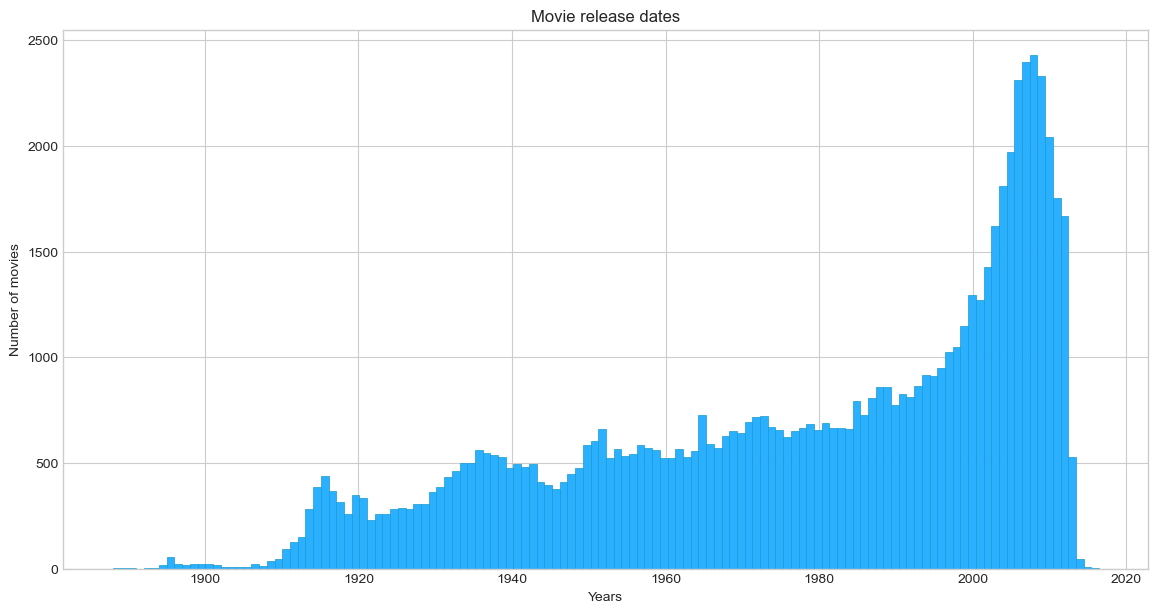

In [29]:
print('The last film in our dataframe was released in', movie_metadata.Movie_release_date.max().year,'and the first one in',movie_metadata.Movie_release_date.min().year)
num_years=(movie_metadata.Movie_release_date.max().year-movie_metadata.Movie_release_date.min().year)

plt.figure(figsize=(14,7))
plt.style.use('seaborn-whitegrid')
plt.hist(movie_metadata['Movie_release_date'],bins=num_years, facecolor = '#2ab0ff', edgecolor='#169acf', linewidth=0.5)
plt.title('Movie release dates') 
plt.xlabel('Years') 
plt.ylabel('Number of movies') 
plt.show()

As we can see the first film seems to have been released in 1888, it is in fact a short sequence of less than 3 seconds. But for our analysis it isn't releavant. Even if there is a debate on which is the fisrt "real movie" we will consider that it is "A trip to the Moon", which is often taught at school. So we will consider movies starting from 1902, and this seems relevant in view of the plot above! 

Source: https://www.studiobinder.com/blog/what-was-the-first-movie-ever-made/

In [30]:
movie_metadata=movie_metadata[~(movie_metadata['Movie_release_date'] <= '1902-01-01')]

## Additional datasets preprocessing

In [31]:
movie_appreciation_metadata.isna().any()

color                         True
director_name                 True
num_critic_for_reviews        True
duration                      True
director_facebook_likes       True
actor_3_facebook_likes        True
actor_2_name                  True
actor_1_facebook_likes        True
gross                         True
genres                       False
actor_1_name                  True
movie_title                  False
num_voted_users              False
cast_total_facebook_likes    False
actor_3_name                  True
facenumber_in_poster          True
plot_keywords                 True
movie_imdb_link              False
num_user_for_reviews          True
language                      True
country                       True
content_rating                True
budget                        True
title_year                    True
actor_2_facebook_likes        True
imdb_score                   False
aspect_ratio                  True
movie_facebook_likes         False
dtype: bool

Sum of NaN in each feature : 


color                         19
director_name                104
num_critic_for_reviews        50
duration                      15
director_facebook_likes      104
actor_3_facebook_likes        23
actor_2_name                  13
actor_1_facebook_likes         7
gross                        884
genres                         0
actor_1_name                   7
movie_title                    0
num_voted_users                0
cast_total_facebook_likes      0
actor_3_name                  23
facenumber_in_poster          13
plot_keywords                153
movie_imdb_link                0
num_user_for_reviews          21
language                      12
country                        5
content_rating               303
budget                       492
title_year                   108
actor_2_facebook_likes        13
imdb_score                     0
aspect_ratio                 329
movie_facebook_likes           0
dtype: int64

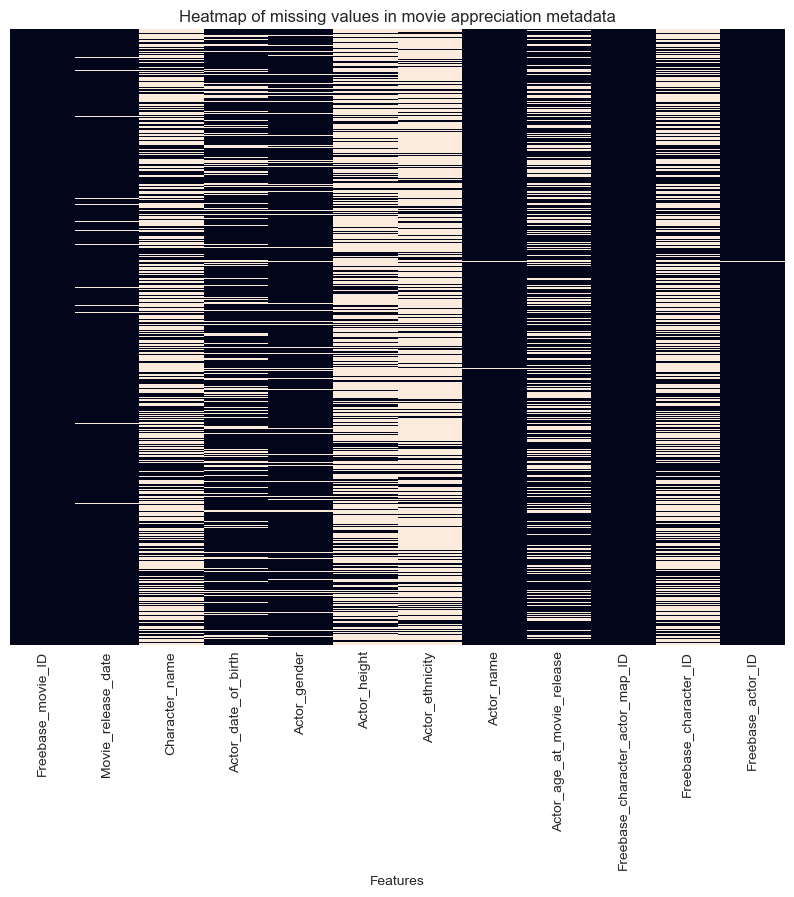

In [32]:
fig, ax = plt.subplots(figsize=(10,8)) 
sns.heatmap(character_metadata.isna(), yticklabels=False, cbar=False)
ax.set(xlabel="Features", ylabel="")
ax.set_title('Heatmap of missing values in movie appreciation metadata')
print('Sum of NaN in each feature : ')
movie_appreciation_metadata.isna().sum(axis = 0)

In [33]:
movie_oscar_winners.isna().any()

Year        False
Ceremony    False
Award       False
Winner       True
Name        False
Film         True
dtype: bool

We do not consider the column 'winner' as it contains indicators (1 and 0) to check wether a movie, an actor or a director has won the oscar. 

Sum of NaN in each feature : 


Year          0
Ceremony      0
Award         0
Name          0
Film        333
dtype: int64

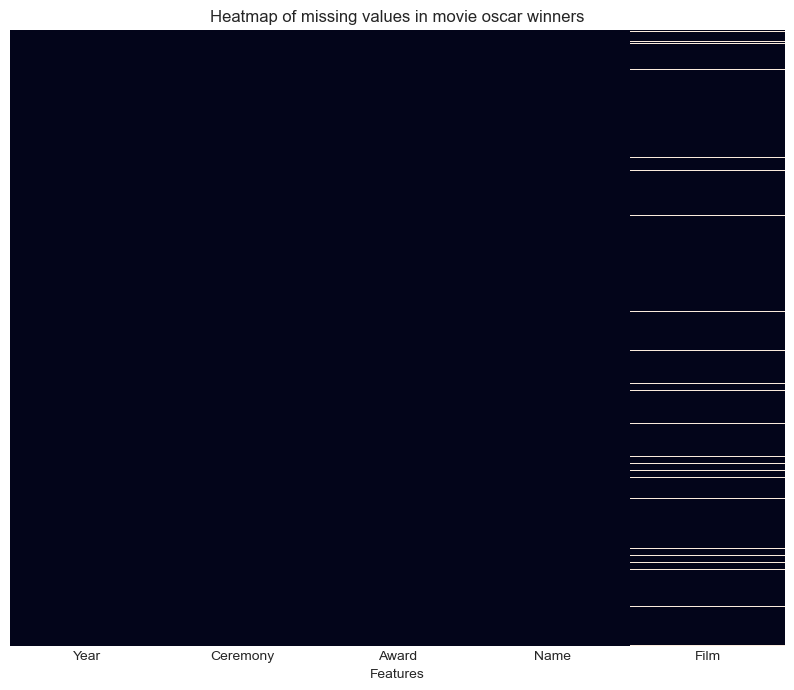

In [34]:
fig, ax = plt.subplots(figsize=(10,8)) 
sns.heatmap(movie_oscar_winners[['Year','Ceremony','Award','Name','Film']].isna(), yticklabels=False, cbar=False)
ax.set(xlabel="Features", ylabel="")
ax.set_title('Heatmap of missing values in movie oscar winners')
print('Sum of NaN in each feature : ')

movie_oscar_winners[['Year','Ceremony','Award','Name','Film']].isna().sum(axis = 0)

## First insights on gender gap <a id="First_insights"> </a>

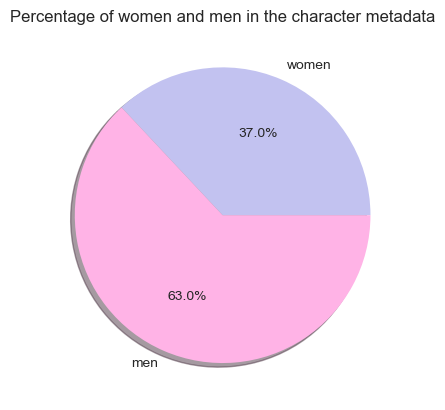

In [35]:
#Plotting on a pie chart the percentage of women and men in the character metadata
fem_act = character_metadata[character_metadata['Actor_gender'] == 'F']
masc_act = character_metadata[character_metadata['Actor_gender'] == 'M']
plt.pie(np.array([fem_act['Actor_name'].nunique(),masc_act['Actor_name'].nunique()]),labels=['women','men'],colors = ['#c2c2f0','#ffb3e6'],autopct='%1.1f%%',shadow=True)
plt.title('Percentage of women and men in the character metadata')
plt.show()

In [36]:
#replace NaN values with 0
character_metadata_clean = character_metadata.fillna(0)
movie_metadata_clean = movie_metadata.fillna(0)

In [37]:
#new dataframe with movies after 2007 after converting the release date to datetime some dates are only year so we need to add the month and day

movie_metadata_clean['Movie_release_date'] = pd.to_datetime(movie_metadata_clean['Movie_release_date'],errors='coerce')
movie_metadata_clean = movie_metadata_clean[movie_metadata_clean['Movie_release_date'] > datetime(2007,1,1)]
movie_metadata_clean.head()

,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
Wikipedia_movie_ID,,,,,,,,
21926710,/m/05p45cv,White on Rice,2009-01-01,0.0,82.0,[],[United States of America],"[Romantic comedy, Romance Film, Comedy, Indie]"
20604092,/m/0523t_1,Anbu Thozhi,2007-08-17,0.0,0.0,[Tamil Language],[India],[Romance Film]
29772142,/m/0fq260_,Karayilekku Oru Kadal Dooram,2010-12-31,0.0,110.0,[Malayalam Language],[India],[Drama]
26623942,/m/0bh9fbk,Kausthubham,2010-03-19,0.0,0.0,[Malayalam Language],[India],[Drama]
32445576,/m/0gyv1h1,Vinayaka Geleyara Balaga,2011-07-15,0.0,0.0,[],[],[]


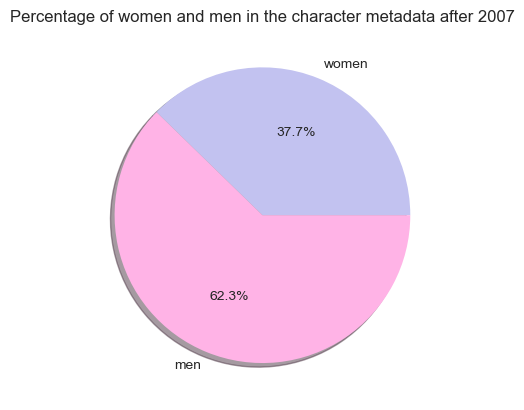

In [38]:
#only keep characters with 'wikipedia movie ID' in movie_metadata_clean after 2007
character_metadata_clean = character_metadata_clean[character_metadata_clean.index.isin(movie_metadata_clean.index)]
#number of female actors compared to male actors for movies after 2007 plotted in a pie chart
fem_act = character_metadata_clean[character_metadata_clean['Actor_gender'] == 'F']
masc_act = character_metadata_clean[character_metadata_clean['Actor_gender'] == 'M']
plt.pie(np.array([fem_act['Actor_name'].nunique(),masc_act['Actor_name'].nunique()]),labels=['women','men'],colors = ['#c2c2f0','#ffb3e6'],autopct='%1.1f%%',shadow=True)
plt.title('Percentage of women and men in the character metadata after 2007')
plt.show()

We can at least see that there's a small increase of 0.7% in the distribution for women on screen after 2007.

In [39]:
#merge character metadata with plot summaries

plot_summaries = plot_summaries.join(character_metadata, on='Wikipedia_movie_ID')
plot_summaries=plot_summaries.dropna()
plot_summaries.head()

,Plot_Summary,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID
Wikipedia_movie_ID,,,,,,,,,,,,,
31186339,The nation of Panem consists of a wealthy Capi...,/m/0gkz15s,2012-03-12,Gale Hawthorne,1990-01-13,M,1.910,/m/0bbz66j,Liam Hemsworth,22.0,/m/0gw7kv7,/m/0ds96_p,/m/04yd0fh
31186339,The nation of Panem consists of a wealthy Capi...,/m/0gkz15s,2012-03-12,Caesar Flickerman,1960-11-11,M,1.721,/m/0xnvg,Stanley Tucci,51.0,/m/0gw7kw1,/m/0gwc3bn,/m/02bj6k
31186339,The nation of Panem consists of a wealthy Capi...,/m/0gkz15s,2012-03-12,President Snow,1935-07-17,M,1.930,/m/07bch9,Donald Sutherland,76.0,/m/0gwc391,/m/0dsbx11,/m/0ywqc
31186339,The nation of Panem consists of a wealthy Capi...,/m/0gkz15s,2012-03-12,Cinna,1964-05-26,M,1.740,/m/041rx,Lenny Kravitz,47.0,/m/0gw7kvx,/m/0gwc39n,/m/0161sp
31186339,The nation of Panem consists of a wealthy Capi...,/m/0gkz15s,2012-03-12,Claudius Templesmith,1966-09-07,M,1.650,/m/0d7wh,Toby Jones,45.0,/m/0j5lh7t,/m/0j5lh7x,/m/071ywj


/var/folders/b2/wj0s08n55d98vq74yyqgdlh40000gn/T/ipykernel_46176/1070814605.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_summaries_new['Movie_release_date'] = pd.to_datetime(plot_summaries_new['Movie_release_date'],errors='coerce')
/var/folders/b2/wj0s08n55d98vq74yyqgdlh40000gn/T/ipykernel_46176/1070814605.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  plot_summaries_new['Movie_release_date'] = plot_summaries_new['Movie_release_date'].dt.year


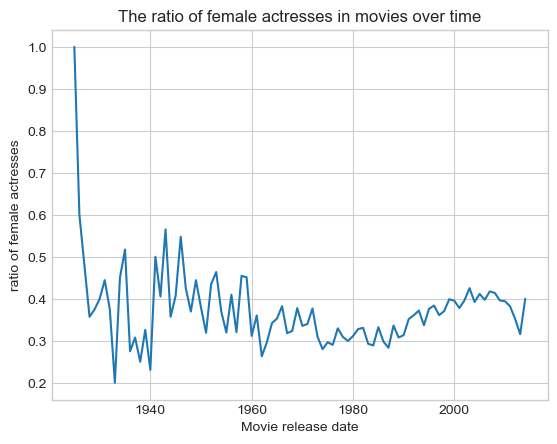

In [42]:
#create new dataframe where we change movie release date to datetime in plot_summaries
plot_summaries_new = plot_summaries[['Freebase_movie_ID', 'Movie_release_date','Actor_gender']]
plot_summaries_new['Movie_release_date'] = pd.to_datetime(plot_summaries_new['Movie_release_date'],errors='coerce')
plot_summaries_new['Movie_release_date'] = plot_summaries_new['Movie_release_date'].dt.year
plot_summaries_new
#calculate the number of 'F' for every 'Movie release date'
plot_summaries_new = plot_summaries_new.groupby(['Movie_release_date','Actor_gender']).size().reset_index(name='counts')
plot_summaries_new[170:180]
#add the total counts for every 'Movie release date'
plot_summaries_new['total_counts'] = plot_summaries_new.groupby('Movie_release_date')['counts'].transform('sum')
plot_summaries_new
#find the ratio of 'F' counts to total counts for every 'Movie release date'
plot_summaries_new['ratio'] = plot_summaries_new.groupby('Movie_release_date')['counts'].apply(lambda x: x/x.sum())
plot_summaries_new
#only keep the 'F' rows
plot_summaries_new = plot_summaries_new[plot_summaries_new['Actor_gender'] == 'F']
plot_summaries_new
#plot the 'Movie release date' and 'ratio' in a line graph
plt.plot(plot_summaries_new['Movie_release_date'], plot_summaries_new['ratio'])
plt.xlabel('Movie release date')
plt.ylabel('ratio of female actresses')
plt.title('The ratio of female actresses in movies over time')
plt.show()

We can interpret from the graph that the ratio of female actresses is clearly lower than half in the years between 1930 and 2010s where the data is most relevant. So actresses are less present than actors in the movies' main characters. We will keep on analysing this data in the next milestone.

## Salaries, box office revenues, etc. <a id="Box_Office"> </a>

We start out by visualizing and analyzing what we know about box office revenues.

In [43]:
print("Movies with biggest box office revenues:")
movie_metadata.sort_values('Movie_box_office_revenue', ascending = False).head()

Movies with biggest box office revenues:


,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
Wikipedia_movie_ID,,,,,,,,
4273140,/m/0bth54,Avatar,2009-12-10,2.782275e+09,178.0,"[English Language, Spanish Language]","[United States of America, United Kingdom]","[Thriller, Science Fiction, Adventure, Compute..."
52371,/m/0dr_4,Titanic,1997-11-01,2.185372e+09,194.0,"[Italian Language, English Language, French La...",[United States of America],"[Tragedy, Costume drama, Historical fiction, A..."
22114132,/m/062zm5h,The Avengers,2012-04-11,1.511758e+09,137.0,"[Russian Language, English Language]",[United States of America],"[Science Fiction, Action]"
31941988,/m/0gvsynb,Harry Potter and the Deathly Hallows – Part 2,2011-07-07,1.328111e+09,130.0,[English Language],"[United States of America, United Kingdom]","[Drama, Mystery, Fantasy, Adventure]"
25001260,/m/0872p_c,Transformers: Dark of the Moon,2011-06-23,1.123747e+09,157.0,[English Language],[United States of America],"[Alien Film, Science Fiction, Action, Adventure]"


In [44]:
print("{:.2%} of the movies have a missing movie box office revenue value".format(movie_metadata.isnull().sum()['Movie_box_office_revenue']/len(movie_metadata)))

89.70% of the movies have a missing movie box office revenue value


As we see above, a lot of the data on the movie box office revenue is missing. This could be problematic as our analysis will focus solely on a partial amount of our dataset. It might make more sense to look at some kind of rating, such ad IMDb rating, to assess whether the movie was successful or not and to try to make sense of how gender is linked to the success of movies.

In [45]:
#Find movies without box office revenue and filter them out
no_rev = movie_metadata.loc[movie_metadata['Movie_box_office_revenue'].isnull()].index
movie_metadata_filt = movie_metadata.drop(no_rev)
movie_metadata_filt['Movie_release_date'] = pd.to_datetime(movie_metadata_filt['Movie_release_date'],errors='coerce')

In [46]:
movie_metadata.shape[0]

81529

In [47]:
movie_metadata_filt.shape[0]

8400

We only have 8401 movies where we have their box office revenue.

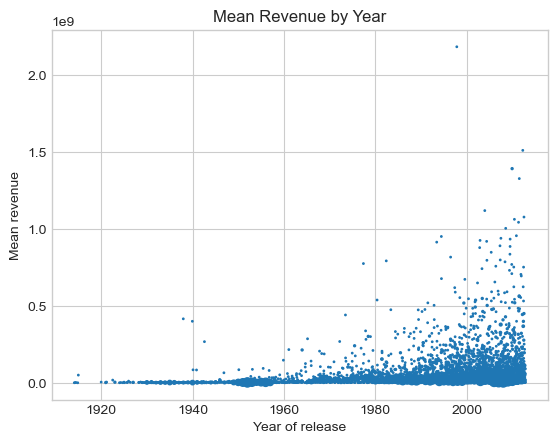

In [48]:
revenue_year = movie_metadata_filt.groupby("Movie_release_date")['Movie_box_office_revenue'].agg(['mean','size']).reset_index()
revenue_year.plot(kind = 'scatter', x = 'Movie_release_date', y = 'mean',s = 'size')
plt.title('Mean Revenue by Year')
plt.ylabel('Mean revenue')
plt.xlabel('Year of release')
plt.show()

From the movies which we have the box office revenue of, we observe a tendency to rise along the years. This is easily explained by the fact that the movie industry has grown over the years and that it generates more and more money through the years.

In [49]:
display(character_metadata.head())
display(movie_metadata.head())

,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID
Wikipedia_movie_ID,,,,,,,,,,,,
975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg


,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
Wikipedia_movie_ID,,,,,,,,
975900,/m/03vyhn,Ghosts of Mars,2001-08-24,14010832.0,98.0,[English Language],[United States of America],"[Thriller, Science Fiction, Horror, Adventure,..."
3196793,/m/08yl5d,Getting Away with Murder: The JonBenét Ramsey ...,2000-02-16,NaN,95.0,[English Language],[United States of America],"[Mystery, Biographical film, Drama, Crime Drama]"
28463795,/m/0crgdbh,Brun bitter,1988-01-01,NaN,83.0,[Norwegian Language],[Norway],"[Crime Fiction, Drama]"
9363483,/m/0285_cd,White Of The Eye,1987-01-01,NaN,110.0,[English Language],[United Kingdom],"[Thriller, Erotic thriller, Psychological thri..."
261236,/m/01mrr1,A Woman in Flames,1983-01-01,NaN,106.0,[German Language],[Germany],[Drama]


We merge our character_metadata dataset and our movie_metadata dataset to try and visualize the difference in box office revenues according to the differenct actor's genders.
We do an inner join because there are movies in the movie_metadata dataset for which we do not have any information on the characters in character_metadata and vice versa.
For further analysis, we need information about both the characters and the movies they appear in.

In [50]:
characters_movie=pd.merge(character_metadata,movie_metadata_filt,left_index=True,right_index=True,how="inner")
characters_movie['Movie_release_date_x'] = pd.to_datetime(characters_movie['Movie_release_date_x'],errors='coerce')
characters_movie.head()

,Freebase_movie_ID_x,Movie_release_date_x,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID,Freebase_movie_ID_y,Movie_name,Movie_release_date_y,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
Wikipedia_movie_ID,,,,,,,,,,,,,,,,,,,,
3217,/m/014hr,1992-10-09,S-Mart Clerk,1965-12-14,M,1.87,NaN,Ted Raimi,26.0,/m/0hgcnkm,/m/0hgcnkq,/m/07qn0,/m/014hr,Army of Darkness,1992-10-09,21502796.0,81.0,[English Language],[United States of America],"[Cult, Horror, Stop motion, Costume drama, Act..."
3217,/m/014hr,1992-10-09,Fake shemp,1956,M,NaN,NaN,Ivan Raimi,36.0,/m/04hzm56,/m/089hc6,/m/0gmjf8,/m/014hr,Army of Darkness,1992-10-09,21502796.0,81.0,[English Language],[United States of America],"[Cult, Horror, Stop motion, Costume drama, Act..."
3217,/m/014hr,1992-10-09,Ash Williams,1958-06-22,M,1.85,NaN,Bruce Campbell,34.0,/m/0jtqtd,/m/06_krl,/m/01h8f,/m/014hr,Army of Darkness,1992-10-09,21502796.0,81.0,[English Language],[United States of America],"[Cult, Horror, Stop motion, Costume drama, Act..."
3217,/m/014hr,1992-10-09,Evil Ash,1958-06-22,M,1.85,NaN,Bruce Campbell,34.0,/m/0jtgxg0,/m/0jtgxg3,/m/01h8f,/m/014hr,Army of Darkness,1992-10-09,21502796.0,81.0,[English Language],[United States of America],"[Cult, Horror, Stop motion, Costume drama, Act..."
3217,/m/014hr,1992-10-09,Cowardly Warrior,1965-12-14,M,1.87,NaN,Ted Raimi,26.0,/m/04hzm5x,/m/0hgcnjh,/m/07qn0,/m/014hr,Army of Darkness,1992-10-09,21502796.0,81.0,[English Language],[United States of America],"[Cult, Horror, Stop motion, Costume drama, Act..."


In [51]:
characters_movie_F = characters_movie[characters_movie['Actor_gender'] == 'F']
characters_movie_M = characters_movie[characters_movie['Actor_gender'] == 'M']

In [52]:
display(characters_movie_F.head())
display(characters_movie_F.head())

,Freebase_movie_ID_x,Movie_release_date_x,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID,Freebase_movie_ID_y,Movie_name,Movie_release_date_y,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
Wikipedia_movie_ID,,,,,,,,,,,,,,,,,,,,
3217,/m/014hr,1992-10-09,Linda,1964-01-27,F,1.68,/m/07hwkr,Bridget Fonda,28.0,/m/0jtqtq,/m/0h2hxrl,/m/01yd8v,/m/014hr,Army of Darkness,1992-10-09,21502796.0,81.0,[English Language],[United States of America],"[Cult, Horror, Stop motion, Costume drama, Act..."
3217,/m/014hr,1992-10-09,Sheila,1965-08-11,F,1.73,/m/06v41q,Embeth Davidtz,27.0,/m/0jtqtk,/m/0h36j9w,/m/034b7r,/m/014hr,Army of Darkness,1992-10-09,21502796.0,81.0,[English Language],[United States of America],"[Cult, Horror, Stop motion, Costume drama, Act..."
3217,/m/014hr,1992-10-09,Possessed Witch,1957-09-04,F,1.75,NaN,Patricia Tallman,35.0,/m/04hzm5r,/m/0hgcnl6,/m/045kf0,/m/014hr,Army of Darkness,1992-10-09,21502796.0,81.0,[English Language],[United States of America],"[Cult, Horror, Stop motion, Costume drama, Act..."
3333,/m/0151l,1915-01-01,NaN,1893-10-14,F,1.66,NaN,Lillian Gish,NaN,/m/0k4hhp,NaN,/m/01c2sl,/m/0151l,The Birth of a Nation,1915-01-01,50000000.0,190.0,"[Silent film, English Language]",[United States of America],"[Silent film, Indie, Costume drama, Epic, Blac..."
3333,/m/0151l,1915-01-01,NaN,1894-11-09,F,1.60,NaN,Mae Marsh,NaN,/m/0k4hh_,NaN,/m/0735gw,/m/0151l,The Birth of a Nation,1915-01-01,50000000.0,190.0,"[Silent film, English Language]",[United States of America],"[Silent film, Indie, Costume drama, Epic, Blac..."


,Freebase_movie_ID_x,Movie_release_date_x,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID,Freebase_movie_ID_y,Movie_name,Movie_release_date_y,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres
Wikipedia_movie_ID,,,,,,,,,,,,,,,,,,,,
3217,/m/014hr,1992-10-09,Linda,1964-01-27,F,1.68,/m/07hwkr,Bridget Fonda,28.0,/m/0jtqtq,/m/0h2hxrl,/m/01yd8v,/m/014hr,Army of Darkness,1992-10-09,21502796.0,81.0,[English Language],[United States of America],"[Cult, Horror, Stop motion, Costume drama, Act..."
3217,/m/014hr,1992-10-09,Sheila,1965-08-11,F,1.73,/m/06v41q,Embeth Davidtz,27.0,/m/0jtqtk,/m/0h36j9w,/m/034b7r,/m/014hr,Army of Darkness,1992-10-09,21502796.0,81.0,[English Language],[United States of America],"[Cult, Horror, Stop motion, Costume drama, Act..."
3217,/m/014hr,1992-10-09,Possessed Witch,1957-09-04,F,1.75,NaN,Patricia Tallman,35.0,/m/04hzm5r,/m/0hgcnl6,/m/045kf0,/m/014hr,Army of Darkness,1992-10-09,21502796.0,81.0,[English Language],[United States of America],"[Cult, Horror, Stop motion, Costume drama, Act..."
3333,/m/0151l,1915-01-01,NaN,1893-10-14,F,1.66,NaN,Lillian Gish,NaN,/m/0k4hhp,NaN,/m/01c2sl,/m/0151l,The Birth of a Nation,1915-01-01,50000000.0,190.0,"[Silent film, English Language]",[United States of America],"[Silent film, Indie, Costume drama, Epic, Blac..."
3333,/m/0151l,1915-01-01,NaN,1894-11-09,F,1.60,NaN,Mae Marsh,NaN,/m/0k4hh_,NaN,/m/0735gw,/m/0151l,The Birth of a Nation,1915-01-01,50000000.0,190.0,"[Silent film, English Language]",[United States of America],"[Silent film, Indie, Costume drama, Epic, Blac..."


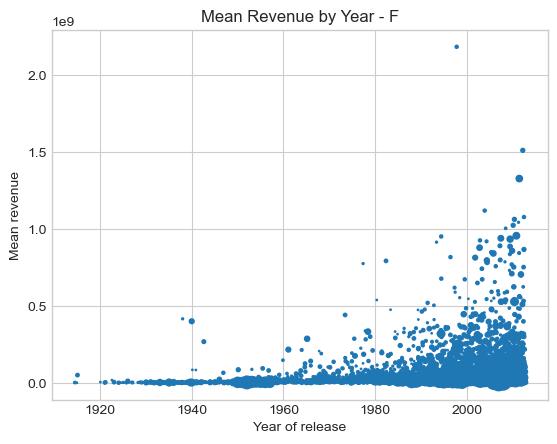

In [53]:
revenue_year = characters_movie_F.groupby("Movie_release_date_x")['Movie_box_office_revenue'].agg(['mean','size']).reset_index()
revenue_year.plot(kind = 'scatter', x = 'Movie_release_date_x', y = 'mean',s = 'size')
plt.title('Mean Revenue by Year - F')
plt.ylabel('Mean revenue')
plt.xlabel('Year of release')
plt.show()

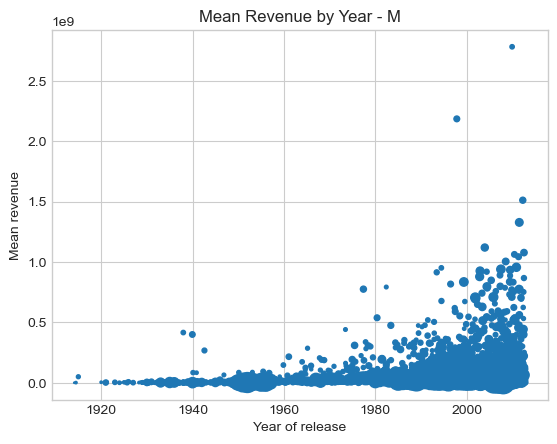

In [54]:
revenue_year = characters_movie_M.groupby("Movie_release_date_x")['Movie_box_office_revenue'].agg(['mean','size']).reset_index()
revenue_year.plot(kind = 'scatter', x = 'Movie_release_date_x', y = 'mean',s = 'size')
plt.title('Mean Revenue by Year - M')
plt.ylabel('Mean revenue')
plt.xlabel('Year of release')
plt.show()

From what we can see on this first visualization, it seems like movies with male characters en up having a bigger mean revenue in box office revenue compared to movies with female characters.

We did not manage to find any data on the actor's salaries for each movies. This would've been a way to visualize discrimination between genders and we will continue to look in case we end up finding some data.

## Detecting main characters <a id="Main_characters"> </a>

In [63]:
plot_summaries.head()
character_metadata.head()
character_metadata=character_metadata.drop_duplicates()
print('there are normally', len(character_metadata),'characters')

there are normally 450669 characters


In [64]:
character_dropna_name = character_metadata.dropna(subset=['Character_name'])
print('Percentage of missing entries in the name of the characters dataset:\n', 100*character_metadata[['Character_name']].isna().sum() / n_char)
character_dropna_name

Percentage of missing entries in the name of the characters dataset:
 Character_name    57.220488
dtype: float64


,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID
Wikipedia_movie_ID,,,,,,,,,,,,
975900,/m/03vyhn,2001-08-24,Akooshay,1958-08-26,F,1.620,NaN,Wanda De Jesus,42.0,/m/0bgchxw,/m/0bgcj3x,/m/03wcfv7
975900,/m/03vyhn,2001-08-24,Lieutenant Melanie Ballard,1974-08-15,F,1.780,/m/044038p,Natasha Henstridge,27.0,/m/0jys3m,/m/0bgchn4,/m/0346l4
975900,/m/03vyhn,2001-08-24,Desolation Williams,1969-06-15,M,1.727,/m/0x67,Ice Cube,32.0,/m/0jys3g,/m/0bgchn_,/m/01vw26l
975900,/m/03vyhn,2001-08-24,Sgt Jericho Butler,1967-09-12,M,1.750,NaN,Jason Statham,33.0,/m/02vchl6,/m/0bgchnq,/m/034hyc
975900,/m/03vyhn,2001-08-24,Bashira Kincaid,1977-09-25,F,1.650,NaN,Clea DuVall,23.0,/m/02vbb3r,/m/0bgchp9,/m/01y9xg
...,...,...,...,...,...,...,...,...,...,...,...,...
913762,/m/03pcrp,1992-05-21,UN Spacy Commander,1954,M,NaN,NaN,Sonny Byrkett,38.0,/m/0kr407w,/m/0kr407_,/m/0gn4bz
913762,/m/03pcrp,1992-05-21,Silvie Gena,1958,F,NaN,NaN,Susan Byrkett,34.0,/m/0kr40b9,/m/0kr40bf,/m/0gn4nd
913762,/m/03pcrp,1992-05-21,Exegran,NaN,M,NaN,NaN,Hal Cleaveland,NaN,/m/0kr407c,/m/0kr406_,/m/0kr407h


In [65]:
characters_plot=pd.merge(character_dropna_name,plot_summaries,left_index=True,right_index=True,how="inner")
characters_plot.head()

,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID,Plot_Summary
Wikipedia_movie_ID,,,,,,,,,,,,,
3217,/m/014hr,1992-10-09,S-Mart Clerk,1965-12-14,M,1.87,NaN,Ted Raimi,26.0,/m/0hgcnkm,/m/0hgcnkq,/m/07qn0,"After being pulled through a time portal, Ash ..."
3217,/m/014hr,1992-10-09,Fake shemp,1956,M,NaN,NaN,Ivan Raimi,36.0,/m/04hzm56,/m/089hc6,/m/0gmjf8,"After being pulled through a time portal, Ash ..."
3217,/m/014hr,1992-10-09,Ash Williams,1958-06-22,M,1.85,NaN,Bruce Campbell,34.0,/m/0jtqtd,/m/06_krl,/m/01h8f,"After being pulled through a time portal, Ash ..."
3217,/m/014hr,1992-10-09,Evil Ash,1958-06-22,M,1.85,NaN,Bruce Campbell,34.0,/m/0jtgxg0,/m/0jtgxg3,/m/01h8f,"After being pulled through a time portal, Ash ..."
3217,/m/014hr,1992-10-09,Cowardly Warrior,1965-12-14,M,1.87,NaN,Ted Raimi,26.0,/m/04hzm5x,/m/0hgcnjh,/m/07qn0,"After being pulled through a time portal, Ash ..."


In [66]:
characters_plot['Movie_release_date'] = pd.to_datetime(characters_plot['Movie_release_date'],errors='coerce')
characters_plot['Actor_date_of_birth'] = pd.to_datetime(characters_plot['Actor_date_of_birth'],errors='coerce') #might need to automate the process here
print('we will consider', len(character_dropna_name), 'characters and', len(characters_plot.index.drop_duplicates()),'movies')
characters_plot.head()

we will consider 192794 characters and 23068 movies


,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID,Plot_Summary
Wikipedia_movie_ID,,,,,,,,,,,,,
3217,/m/014hr,1992-10-09,S-Mart Clerk,1965-12-14,M,1.87,NaN,Ted Raimi,26.0,/m/0hgcnkm,/m/0hgcnkq,/m/07qn0,"After being pulled through a time portal, Ash ..."
3217,/m/014hr,1992-10-09,Fake shemp,1956-01-01,M,NaN,NaN,Ivan Raimi,36.0,/m/04hzm56,/m/089hc6,/m/0gmjf8,"After being pulled through a time portal, Ash ..."
3217,/m/014hr,1992-10-09,Ash Williams,1958-06-22,M,1.85,NaN,Bruce Campbell,34.0,/m/0jtqtd,/m/06_krl,/m/01h8f,"After being pulled through a time portal, Ash ..."
3217,/m/014hr,1992-10-09,Evil Ash,1958-06-22,M,1.85,NaN,Bruce Campbell,34.0,/m/0jtgxg0,/m/0jtgxg3,/m/01h8f,"After being pulled through a time portal, Ash ..."
3217,/m/014hr,1992-10-09,Cowardly Warrior,1965-12-14,M,1.87,NaN,Ted Raimi,26.0,/m/04hzm5x,/m/0hgcnjh,/m/07qn0,"After being pulled through a time portal, Ash ..."


In [67]:
#merge character metadata with plot summaries

plot_summaries = plot_summaries.join(character_metadata, on='Wikipedia_movie_ID')
plot_summaries=plot_summaries.dropna()
plot_summaries

,Plot_Summary,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID
Wikipedia_movie_ID,,,,,,,,,,,,,
31186339,The nation of Panem consists of a wealthy Capi...,/m/0gkz15s,2012-03-12,Gale Hawthorne,1990-01-13,M,1.910,/m/0bbz66j,Liam Hemsworth,22.0,/m/0gw7kv7,/m/0ds96_p,/m/04yd0fh
31186339,The nation of Panem consists of a wealthy Capi...,/m/0gkz15s,2012-03-12,Caesar Flickerman,1960-11-11,M,1.721,/m/0xnvg,Stanley Tucci,51.0,/m/0gw7kw1,/m/0gwc3bn,/m/02bj6k
31186339,The nation of Panem consists of a wealthy Capi...,/m/0gkz15s,2012-03-12,President Snow,1935-07-17,M,1.930,/m/07bch9,Donald Sutherland,76.0,/m/0gwc391,/m/0dsbx11,/m/0ywqc
31186339,The nation of Panem consists of a wealthy Capi...,/m/0gkz15s,2012-03-12,Cinna,1964-05-26,M,1.740,/m/041rx,Lenny Kravitz,47.0,/m/0gw7kvx,/m/0gwc39n,/m/0161sp
31186339,The nation of Panem consists of a wealthy Capi...,/m/0gkz15s,2012-03-12,Claudius Templesmith,1966-09-07,M,1.650,/m/0d7wh,Toby Jones,45.0,/m/0j5lh7t,/m/0j5lh7x,/m/071ywj
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8605430,The story develops around the evolution of Tit...,/m/0279p_0,2002,Titli,1979-12-03,F,1.550,/m/0dryh9k,Konkona Sen Sharma,22.0,/m/02tb7xb,/m/04hqnqj,/m/09w3dt
4913923,"In Northern Norway during the 1860s, a little ...",/m/0cty8f,2002-03-08,Leo Zhukovsky,1964-02-16,M,1.830,/m/02w7gg,Christopher Eccleston,38.0,/m/0jzpw0,/m/0h0v5q0,/m/02cbs0
4913923,"In Northern Norway during the 1860s, a little ...",/m/0cty8f,2002-03-08,Niels,1965-11-22,M,1.830,/m/0268_k,Mads Mikkelsen,36.0,/m/04d89tq,/m/0h39rc3,/m/076svb


In [68]:
#create a function that counts the occurence of a word in a string
def count_word(word, string):
    return string.count(word)

#count the number of times each character is mentioned in the plot summary
plot_summaries['Character_occurence'] = plot_summaries.apply(lambda x: count_word(x['Character_name'], x['Plot_Summary']), axis=1)

In [69]:
plot_summaries

,Plot_Summary,Freebase_movie_ID,Movie_release_date,Character_name,Actor_date_of_birth,Actor_gender,Actor_height,Actor_ethnicity,Actor_name,Actor_age_at_movie_release,Freebase_character_actor_map_ID,Freebase_character_ID,Freebase_actor_ID,Character_occurence
Wikipedia_movie_ID,,,,,,,,,,,,,,
31186339,The nation of Panem consists of a wealthy Capi...,/m/0gkz15s,2012-03-12,Gale Hawthorne,1990-01-13,M,1.910,/m/0bbz66j,Liam Hemsworth,22.0,/m/0gw7kv7,/m/0ds96_p,/m/04yd0fh,0
31186339,The nation of Panem consists of a wealthy Capi...,/m/0gkz15s,2012-03-12,Caesar Flickerman,1960-11-11,M,1.721,/m/0xnvg,Stanley Tucci,51.0,/m/0gw7kw1,/m/0gwc3bn,/m/02bj6k,1
31186339,The nation of Panem consists of a wealthy Capi...,/m/0gkz15s,2012-03-12,President Snow,1935-07-17,M,1.930,/m/07bch9,Donald Sutherland,76.0,/m/0gwc391,/m/0dsbx11,/m/0ywqc,2
31186339,The nation of Panem consists of a wealthy Capi...,/m/0gkz15s,2012-03-12,Cinna,1964-05-26,M,1.740,/m/041rx,Lenny Kravitz,47.0,/m/0gw7kvx,/m/0gwc39n,/m/0161sp,0
31186339,The nation of Panem consists of a wealthy Capi...,/m/0gkz15s,2012-03-12,Claudius Templesmith,1966-09-07,M,1.650,/m/0d7wh,Toby Jones,45.0,/m/0j5lh7t,/m/0j5lh7x,/m/071ywj,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8605430,The story develops around the evolution of Tit...,/m/0279p_0,2002,Titli,1979-12-03,F,1.550,/m/0dryh9k,Konkona Sen Sharma,22.0,/m/02tb7xb,/m/04hqnqj,/m/09w3dt,12
4913923,"In Northern Norway during the 1860s, a little ...",/m/0cty8f,2002-03-08,Leo Zhukovsky,1964-02-16,M,1.830,/m/02w7gg,Christopher Eccleston,38.0,/m/0jzpw0,/m/0h0v5q0,/m/02cbs0,0
4913923,"In Northern Norway during the 1860s, a little ...",/m/0cty8f,2002-03-08,Niels,1965-11-22,M,1.830,/m/0268_k,Mads Mikkelsen,36.0,/m/04d89tq,/m/0h39rc3,/m/076svb,7


In [70]:
#create dataframe with the highest character occurence for each Freebase movie ID and the corresponding character name and gender

character_occurence = plot_summaries.groupby('Freebase_movie_ID')['Character_occurence'].max().reset_index()
character_occurence = character_occurence.merge(plot_summaries[['Freebase_movie_ID', 'Character_name', 'Character_occurence']], on=['Freebase_movie_ID', 'Character_occurence'], how='left')
character_occurence = character_occurence.drop_duplicates(subset='Freebase_movie_ID', keep='first')
character_occurence = character_occurence.drop('Character_occurence', axis=1)
character_occurence

#add character name and gender to character_occurence
character_occurence = character_occurence.merge(character_metadata[['Freebase_movie_ID', 'Character_name', 'Actor_gender']], on=['Freebase_movie_ID', 'Character_name'], how='left')

character_occurence


,Freebase_movie_ID,Character_name,Actor_gender
0,/m/011wtv,Agatha,F
1,/m/011x_4,Phil Connors,M
2,/m/011xg5,David,M
3,/m/011xrr,Lord John Whorfin,M
4,/m/011ycb,Albert Freedman,M
...,...,...,...
15079,/m/0yyg4,Anderson,M
15080,/m/0yyn5,Jack Trainer,M
15081,/m/0yyts,Hoke Colburn,M
15082,/m/0yzbg,Todd Anderson,M


Freebase_movie_ID    5691
Character_name       5691
Actor_gender         5691
dtype: int64


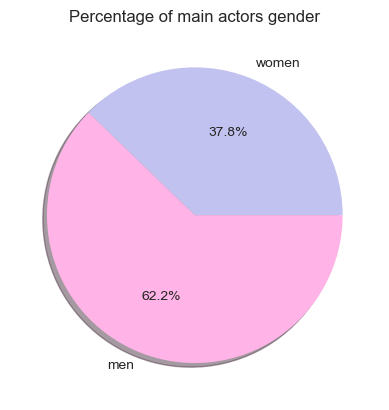

In [71]:
x=character_occurence[character_occurence['Actor_gender'] == 'F'].count()
print(x)
y=character_occurence[character_occurence['Actor_gender'] == 'M'].count()
#plot x and y in a pie chart
plt.pie([x[0] , y[0]],labels=['women','men'],colors = ['#c2c2f0','#ffb3e6'],autopct='%1.1f%%',shadow=True)
plt.title('Percentage of main actors gender')
plt.show()

## Discrimination through types of roles attribution and its evolution in time <a id="Types"> </a>

### Summaries treatment

In [76]:
# feminine pronouns occurence in summaries

In [77]:
def indicator_variable(dic,x,s):
    '''
    Returns indicator variable which equals to 1 if the corresponding headline uses 
    the corresponding type of pronoun and 0 otherwise.
    :param dic: dictionary
    :param x: string
    :param s: string
    :return: indicator variable
    '''
    return int(bool(set(dic[s]) & set(x.lower().split(" "))))

In [78]:
feature_wordsets = dict([
    # https://en.wikipedia.org/wiki/English_personal_pronouns
    ('fem_pronoun', ['she','her','hers','herself', 
                               "she'll", "she's", 'shes']),
    ('masc_pronoun', ['he','him','his','himself',
                               "he'd", "he's", 'hes'])
])

plot_summaries["fem_pronoun"] = plot_summaries["Plot_Summary"].apply(lambda x : indicator_variable(feature_wordsets,x,'fem_pronoun'))
plot_summaries["masc_pronoun"] = plot_summaries["Plot_Summary"].apply(lambda x : indicator_variable(feature_wordsets,x,'masc_pronoun'))


In [79]:
plot_summaries

,Plot_Summary,fem_pronoun,masc_pronoun
Wikipedia_movie_ID,,,
23890098,"Shlykov, a hard-working taxi driver and Lyosha...",0,0
31186339,The nation of Panem consists of a wealthy Capi...,1,1
20663735,Poovalli Induchoodan is sentenced for six yea...,1,1
2231378,"The Lemon Drop Kid , a New York City swindler,...",1,1
595909,Seventh-day Adventist Church pastor Michael Ch...,1,1
...,...,...,...
34808485,"The story is about Reema , a young Muslim scho...",1,0
1096473,"In 1928 Hollywood, director Leo Andreyev look...",1,1
35102018,American Luthier focuses on Randy Parsons’ tra...,0,1


In [80]:
length_summaries = len(plot_summaries)

In [81]:
print('The number of summaries with feminine pronouns occurence:', sum(plot_summaries["fem_pronoun"]))
print('The percentage of summaries with feminine pronouns occurence:', 100*(sum(plot_summaries["fem_pronoun"]))/ length_summaries, "%")

The number of summaries with feminine pronouns occurence: 25181
The percentage of summaries with feminine pronouns occurence: 59.5253291728719 %


In [82]:
print('The number of summaries with masculine pronouns occurence:', sum(plot_summaries["masc_pronoun"]))
print('The percentage of summaries with masculine pronouns occurence:', 100*(sum(plot_summaries["masc_pronoun"]))/ length_summaries, "%")

The number of summaries with masculine pronouns occurence: 35197
The percentage of summaries with masculine pronouns occurence: 83.2021369642815 %


We observe that there is more than 23% difference between the occurence of feminine and masculine pronouns in the given summaries.

We can check if the pronouns occurence changes through time.

In [83]:
# add a release date column to the plot_summaries dataset

summaries_with_date = movie_metadata_filt.join(plot_summaries) #there were more summaries than given movies
summaries_with_date = summaries_with_date.dropna()
summaries_with_date["Movie_release_date"] = pd.to_datetime(summaries_with_date["Movie_release_date"],errors='coerce')
summaries_with_date = summaries_with_date.sort_values(by="Movie_release_date")
summaries_with_date 

,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Plot_Summary,fem_pronoun,masc_pronoun
Wikipedia_movie_ID,,,,,,,,,,,
3333,/m/0151l,The Birth of a Nation,1915-01-01,50000000.0,190.0,"[Silent film, English Language]",[United States of America],"[Silent film, Indie, Costume drama, Epic, Blac...",The film follows two juxtaposed families: the...,1.0,1.0
4499436,/m/0c5ppr,Way Down East,1920-01-01,4500000.0,147.0,"[Silent film, English Language]",[United States of America],"[Silent film, Indie, Black-and-white, Action/A...","The rich, typified by the handsome man-about-t...",1.0,1.0
1346905,/m/04vl27,The Kid,1921-01-01,2500000.0,60.0,"[Silent film, English Language]",[United States of America],"[Silent film, Drama, Indie, Black-and-white, C...",An unwed woman leaves a charity hospital carr...,1.0,1.0
21135479,/m/05b_29y,Little Lord Fauntleroy,1921-01-01,900000.0,112.0,"[Silent film, English Language]",[United States of America],"[Silent film, Drama, Comedy, Black-and-white, ...",Cedric Errol is a poor American boy who finds ...,0.0,1.0
2137591,/m/06pkq3,The Four Horsemen of the Apocalypse,1921-03-06,4500000.0,134.0,"[Silent film, English Language]",[United States of America],"[Silent film, Indie, Black-and-white, Drama, W...",The 1921 film is a fictional story inspired b...,1.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...
33316658,/m/0gydg4g,House at the End of the Street,2012-09-21,31096918.0,101.0,[English Language],[],[Horror],Newly divorced Sarah and her daughter Elissa ...,1.0,1.0
27383563,/m/0by1wkq,Looper,2012-09-28,136513833.0,118.0,[English Language],[United States of America],"[Science Fiction, Action]","By 2044, the United States has suffered econom...",1.0,1.0
35316287,/m/0gh9fjz,Here Comes the Boom,2012-10-12,30610000.0,105.0,[English Language],[United States of America],"[Action, Comedy]",Former collegiate wrestler Scott Voss is a 42...,0.0,1.0


In [88]:
#split dataset into three parts: before 2007, between 2007 and 2016, and after 2016

summaries_before2007 = summaries_with_date[summaries_with_date["Movie_release_date"] < "2007-01-01"]
summaries_2007 = summaries_with_date[(summaries_with_date["Movie_release_date"] >= "2007-01-01") & (summaries_with_date["Movie_release_date"] < "2016-01-01") ]
summaries_2016 = summaries_with_date[summaries_with_date["Movie_release_date"] >= "2016-01-01"]
summaries_2016

,Freebase_movie_ID,Movie_name,Movie_release_date,Movie_box_office_revenue,Movie_runtime,Movie_languages,Movie_countries,Movie_genres,Plot_Summary,fem_pronoun,masc_pronoun
Wikipedia_movie_ID,,,,,,,,,,,


In [89]:
print('The number of summaries before 2007 with feminine pronouns occurence:', sum(summaries_before2007["fem_pronoun"]))
print('The percentage of summaries before 2007 with feminine pronouns occurence:', 100*(sum(summaries_before2007["fem_pronoun"]))/ len(summaries_before2007), "%")

The number of summaries before 2007 with feminine pronouns occurence: 4392.0
The percentage of summaries before 2007 with feminine pronouns occurence: 76.2367644506162 %


In [90]:
print('The number of summaries before 2007 with masculine pronouns occurence:', sum(summaries_before2007["masc_pronoun"]))
print('The percentage of summaries before 2007 with masculine pronouns occurence:', 100*(sum(summaries_before2007["masc_pronoun"]))/ len(summaries_before2007), "%")

The number of summaries before 2007 with masculine pronouns occurence: 5405.0
The percentage of summaries before 2007 with masculine pronouns occurence: 93.82051727130707 %


In [91]:
print('The number of summaries after 2007 with feminine pronouns occurence:', sum(summaries_2007["fem_pronoun"]))
print('The percentage of summaries after 2007 with feminine pronouns occurence:', 100*(sum(summaries_2007["fem_pronoun"]))/ len(summaries_2007), "%")

The number of summaries after 2007 with feminine pronouns occurence: 1330.0
The percentage of summaries after 2007 with feminine pronouns occurence: 78.14336075205641 %


In [92]:
print('The number of summaries after 2007 with masculine pronouns occurence:', sum(summaries_2007["masc_pronoun"]))
print('The percentage of summaries after 2007 with masculine pronouns occurence:', 100*(sum(summaries_2007["masc_pronoun"]))/ len(summaries_2007), "%")

The number of summaries after 2007 with masculine pronouns occurence: 1536.0
The percentage of summaries after 2007 with masculine pronouns occurence: 90.24676850763807 %


The dataset does not contain any row after 2016

On the period before and after 2007, we see a slight increase in feminine pronouns occurence and a slight decrease in masculine pronouns occurence, always with masculine pronouns mainly used in movies summaries. The subgroups tendencies are aligned with the entire group (it is not a Simpson paradox).

These results can not be largely interpreted as the subgroup "before 2007" is five times larger than the "after 2007" subgroup. Results can be biased due to the different number of samples.

We need to find a way to count the number of feminine and masculine pronouns in each summary, compute the mean and the mean difference for both groups. Compare mean number of fem/masc pronouns in function of movies genres, compare this to length of summaries too (maybe action movies have shorter summaries, and they are also more representative of the men population).

The next step would be to correlate the masculine and feminine pronouns occurence with certain genres, and see if it matches certain gender stereotypes.